# Regression Demo

This notebook briefly describes how to make an variational inference with Henbun.

*Keisuke Fujii, 21st Nov. 2016*

We show 
+ Expert model with Gaussian process prior  
that is much more flexible than the simple Gaussian process regression

# Import libraries

In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

import tensorflow as tf
import Henbun as hb

# Toy data

In [2]:
X = np.linspace(0,6,150).reshape(-1,1)
Y = np.sin(0.1*X*X*X) + np.random.randn(*X.shape)*0.1

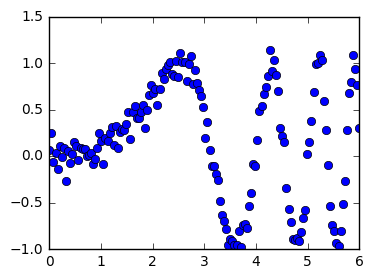

In [3]:
plt.figure(figsize=(4,3))
plt.plot(X,Y,'o')

# Construct a Henbun model

Here, we demonstrate the expert model by Henbun. 

We assume three latent functions, one of which has the shorter lengthscale ($f_s(x)$), another with longer lengthscale ($f_l(x)$).
The last one has largest lengthscale, $r(x)$ and represents the fraction of $f_s(x)$ and $f_l(x)$ to be contributed with respect to the position, i.e.
$$
f(x) = \frac{1}{1+e^{r(x)}} f_s(x) + \frac{1}{1+e^{-r(x)}} f_l(x)
$$

In [4]:
# Any model should inherite hb.model.Model
class ExpertGPR(hb.model.Model):
    def setUp(self):
        """ 
        Set up parameters and Data for this model.
        Model.setUp is immediately called after Model.__init__()
        """
        # Data should be stored in hb.param.Data class. 
        self.X = hb.param.Data(X)
        self.Y = hb.param.Data(Y)
        
        # Variational parameters. 
        # We assume posterior of f_s, f_l, r are independent.
        self.q_s = hb.variationals.Gaussian(shape=X.shape, q_shape='fullrank')
        self.q_l = hb.variationals.Gaussian(shape=X.shape, q_shape='fullrank')
        self.q_r = hb.variationals.Gaussian(shape=X.shape, q_shape='fullrank')
        
        # Kernel object for GPR. 
        self.kern_s = hb.gp.kernels.UnitRBF(np.ones(1)*0.2)
        self.kern_l = hb.gp.kernels.UnitRBF(np.ones(1)*1)
        self.kern_r = hb.gp.kernels.UnitRBF(np.ones(1)*1)
        # Since our kernel does not contain the variance term, we multiply by hand.
        # The variance parameter should be positive.
        # It is possible to constrain k_var to stay in positive space by setting
        # transform option.
        self.k_var = hb.param.Variable(shape=[1], transform=hb.transforms.positive)
        self.k_var_r = hb.param.Variable(shape=[1], transform=hb.transforms.positive)
        
        # likelihood variance
        self.var = hb.param.Variable(shape=[1], transform=hb.transforms.positive)
        
    @hb.model.AutoOptimize()
    def ELBO(self):
        """
        We calculate ELBO that should be maximized in this method.
        """
        # f_s, f_l, f_r is the latent function.
        # Here, we assign them as a member of this class, 
        # which makes it easy to draw the result later.
        self.f_s = tf.matmul(self.kern_s.Cholesky(self.X), self.q_s)
        self.f_l = tf.matmul(self.kern_l.Cholesky(self.X), self.q_l)
        self.f_r = tf.matmul(self.kern_r.Cholesky(self.X), self.q_r) * tf.sqrt(self.k_var_r)
        
        fraction = tf.sigmoid(self.f_r)
        self.f = (fraction * self.f_s + (1-fraction) * self.f_l)*self.k_var
        # Kulback-Leibler divergence can be accessed by self.KL() method.
        return tf.reduce_sum(hb.densities.gaussian(self.Y, self.f, self.var))\
                - self.KL()
        
    @hb.model.AutoOptimize()
    def ELBO_single(self):
        """
        We carry out a usual GPR as an initial estimate.
        """
        # f_s, f_l, f_r is the latent function.
        # Here, we assign them as a member of this class, 
        # which makes it easy to draw the result later.
        f_s = tf.matmul(self.kern_s.Cholesky(self.X), self.q_s)*self.k_var
        # Kulback-Leibler divergence can be accessed by self.KL() method.
        return tf.reduce_sum(hb.densities.gaussian(self.Y, f_s, self.var))\
                - self.KL()

In [5]:
model = ExpertGPR()

# Train the Henbun model

## Numeric issue
We adopt float64 bit computation, although float 32 bit computation is adopted by default.
For changing the float type, we can change by setting method.

Henbun adopted config structure adopted in GPflow.
See https://github.com/GPflow/GPflow/blob/master/doc/source/notebooks/settings.ipynb for the details.

In [6]:
# We can change configuration from setting module
custom_config = hb.settings.get_settings()
custom_config.numerics.jitter_level = 3.0e-4

## Initial optimization

We make an initial estimate by fitting data by a single Gaussian Proces.

In [7]:
# During the compilation, we adopt context manager by temp_setting
with hb.settings.temp_settings(custom_config):
    model.ELBO_single().compile(tf.train.AdamOptimizer(0.01))
    model.ELBO_single().optimize(maxiter=3000)

compiling...


In [8]:
model.kern_s.lengthscales.value

array([ 0.17457114], dtype=float32)

## Adopt the initial estimates.

We copy from the above estimate into model.q_l and model.kern_l.

In [9]:
model.q_l.q_mu = model.q_s.q_mu.value
model.q_l.q_sqrt = model.q_s.q_sqrt.value
model.kern_l.lengthscales = model.kern_s.lengthscales.value + 0.2

In [10]:
# During the compilation, we adopt context manager by temp_setting
with hb.settings.temp_settings(custom_config):
    # First, we need compilation of the model
    model.ELBO().compile(tf.train.AdamOptimizer(0.001))
    # To evaluate this method with current parameters, run() method can be used.
    model.ELBO().run()

compiling...


## Training

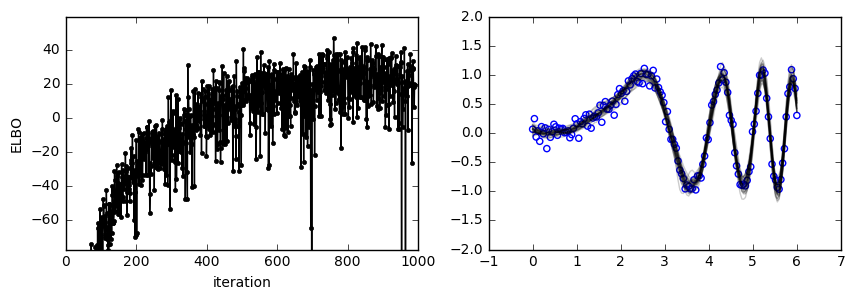

In [11]:
from IPython import display

plt.figure(figsize=(10,3))
logf = []
for i in range(1000):    
    try:
        # run 10 iteration
        model.ELBO().optimize(maxiter=10)
        obj = model.ELBO().run()
        logf.append(obj)
        # display
        if (i % 10) ==0:
            plt.clf()
            plt.subplot(1,2,1)
            plt.plot(logf, '-ko', markersize=3, linewidth=1)
            plt.ylabel('ELBO')
            plt.xlabel('iteration')
            ymin = np.percentile(logf, 10)
            ymax = np.max(logf) + (np.max(logf)-ymin)*0.1
            plt.ylim(ymin, ymax)
            # --- plot for self. ---
            plt.subplot(1,2,2)
            plt.scatter(X, Y, facecolors='none', edgecolors='b', label='data')
            for s in range(30):
                plt.plot(X, model.run(model.f), 'k', alpha=0.2)
            plt.ylim(-2,2)
            display.display(plt.gcf())
            display.clear_output(wait=True)
    except KeyboardInterrupt:
        break

# Draw samples from the posterior

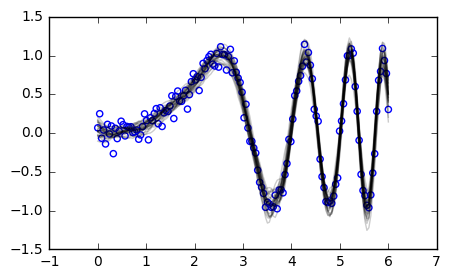

In [12]:
plt.figure(figsize=(5,3))
plt.scatter(X, Y, facecolors='none', edgecolors='b', label='data')
for s in range(30):
    plt.plot(X, model.run(model.f), 'k', alpha=0.2)

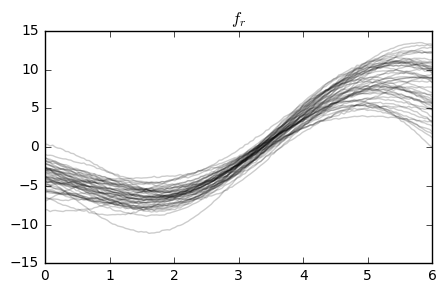

In [13]:
plt.figure(figsize=(5,3))
for s in range(50):
    plt.plot(X, model.run(model.f_r), 'k', alpha=0.2)
plt.title('$f_r$')

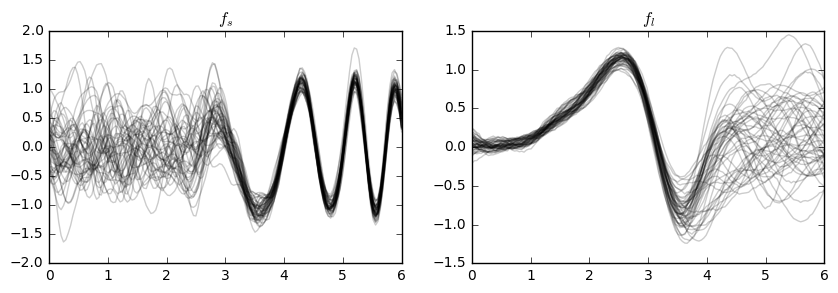

In [14]:
plt.figure(figsize=(10,3))
for s in range(50):
    plt.subplot(1,2,1)
    plt.plot(X, model.run(model.f_s), 'k', alpha=0.2)
    plt.subplot(1,2,2)
    plt.plot(X, model.run(model.f_l), 'k', alpha=0.2)
plt.subplot(1,2,1)
plt.title('$f_s$')
plt.subplot(1,2,2)
plt.title('$f_l$')